<a href="https://colab.research.google.com/github/MaxMLgh/YOLO_tutorial/blob/master/Google_Colab_Yolo_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/MaxMLgh/YOLO_tutorial/master/net/coco.txt -O coco.txt
!wget https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O yolov3.cfg
!wget https://pjreddie.com/media/files/yolov3-tiny.weights -O yolov3-tiny.weights
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg -O yolov3-tiny.cfg
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights -O yolov4.weights
!wget https://raw.githubusercontent.com/MaxMLgh/YOLO_tutorial/master/net/yolov4.cfg -O yolov4.cfg
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights -O yolov4-tiny.weights
!wget https://raw.githubusercontent.com/MaxMLgh/YOLO_tutorial/master/net/yolov4-tiny.cfg -O yolov4-tiny.cfg

--2021-05-23 20:06:23--  https://raw.githubusercontent.com/MaxMLgh/YOLO_tutorial/master/net/coco.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 624 [text/plain]
Saving to: ‘coco.txt’

coco.txt            100%[===================>]     624  --.-KB/s    in 0s      

2021-05-23 20:06:23 (37.1 MB/s) - ‘coco.txt’ saved [624/624]

--2021-05-23 20:06:23--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  41.8MB/s    in 6.1s    

2021-05-23 20:06:30 (38.

In [ ]:
!pip install opencv-python==4.5.1.48 numpy==1.19.2 pafy youtube-dl

     |████████████████████████████████| 50.4MB 124kB/s 
     |████████████████████████████████| 14.5MB 298kB/s 
     |████████████████████████████████| 1.9MB 39.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
import cv2
import numpy as np
np.set_printoptions(suppress=True)
from urllib.request import Request, urlopen
import urllib
import time
import os
import traceback
import pafy
from google.colab.patches import cv2_imshow

In [ ]:
"""
Class Detection consists basically everything useful in this script. It has 4 methods(class functions): 
configure_net, detect, draw_img and keyboard. Those methods share a lot of parameters. 
Instead of returning 20 parameters from one function and passing them into next function, 
I decided to make a class that would store them as variables of a class instance.
In __init__ I just wanted to give a heads up which variables exist and will be used by methods,
but majority of them is filled not in __init__ but in one of those 4 methods.
"""
class Detection:
    font = cv2.FONT_HERSHEY_PLAIN
    colors = ((255,0,0), (0,255,0), (0,0,255), (255,255,0), (0,255,255), (255,0,255), (128,0,0)) 
    
    def __init__(self, model_name = 'yolov3', input_height=416, path_yolo_classes='coco.txt', 
                 output_height=800, is_scale_output = True, MIN_confidence=0.5, IOU_threshold=0.6, 
                 is_blob_aspect_ratio=True, anchor_box_show=False, grid_show=False, show_text_on_box=True, 
                 is_recording=False, show_text_left=False):
        self.model_name = model_name
        self.net = None
        self.anchors = None
        
        self.grids_per_height = round(input_height/32)
        self.grids_per_width = self.grids_per_height
        self.input_height = self.grids_per_height * 32
        self.input_width = self.input_height
        if input_height%32:
            print('''Value of input_height={} is indivisible by 32, 
input_height={} will be used instead. 
Choose input_height that is an integer multiple of 32(eg.320,416,620,...).'''.format(input_height, 
                                                                                self.input_height))
            
        with open(path_yolo_classes, 'r') as f:
            self.classes = f.read().splitlines()
            
        self.anchor_box_show = anchor_box_show
        self.grid_show = grid_show   
        self.show_text_on_box = show_text_on_box
        self.show_text_left = show_text_left
        self.is_recording = is_recording
        self.is_any_frame_recorded = False
        
        self.MIN_confidence = MIN_confidence
        self.IOU_threshold = IOU_threshold
        self.FPS = 0.0
       
        self.img = None
        self.img_name = None
        self.img_with_drawings = None
        self.img_height, self.img_width = None, None
        self.boxes = None
        self.confidences = None
        self.best_class_ids = None
        self.grid_cells = None
        self.anchor_boxes = None
        self.bounding_box_centers = None
        self.detection_outputs = None
        
        self.is_blob_aspect_ratio = is_blob_aspect_ratio
        
        self.is_scale_output = is_scale_output
        self.output_height = output_height
          
        if cv2.cuda.getCudaEnabledDeviceCount():    
            self.is_cuda = True
            print('GPU is enabled.')
        else:
            self.is_cuda = False
            print('GPU is NOT enabled. OpenCV-{} will use CPU instead.'.format(cv2.__version__))
            
    
    """
    In this method we read in a specific model and set up parameters for it.
    """
    def configure_net(self, model_name=None):
          if model_name!=None:
            self.model_name = model_name

          path_weights = '{}.weights'.format(self.model_name)
          path_cfg = '{}.cfg'.format(self.model_name)
          self.net = cv2.dnn.readNet(path_weights, path_cfg)

          if self.is_cuda:
              self.net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
              self.net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
              
          """ Fetching anchor boxes values from .cfg file. """
          with open('{}.cfg'.format(self.model_name), 'r') as f:
              cfg = f.read().splitlines()
              anchors_line = [line for line in cfg if 'anchors' in line][0].replace('anchors', '').replace('=', '')
              anchors = np.array([int(num) for num in anchors_line.split(',')])
              anchors = anchors.reshape(int(len(anchors)/6), 3, 2)[::-1]
              self.anchors = anchors
                
    
    """
    This method runs detection on the image. It saves all parameters of detection as class instance variables.
    It saves ALL the detections above 0.1% accuracy from ALL grids. 
    It does not take into account given confidence and IOU threshold. 
    That will happen in draw_img('cv2.dnn.NMSBoxes') method.
    Thanks to that we only need to run detection on image once. So changing any parameters, besides size 
    and model from keybord level on image or paused video will result in an instant change on image, 
    because we already have all the information from detection, we just need to draw them.
    """    
    def detect(self, img):
        if self.is_blob_aspect_ratio:
            ratio_width2height = img.shape[1]/img.shape[0]
            self.grids_per_width = round((self.input_height * ratio_width2height)/32)
            self.input_width = self.grids_per_width*32
        else:
            self.input_width = self.input_height
            self.grids_per_width = self.grids_per_height
            
        """ Blob is the version of the original image adjusted perfectly for the neural net. """
        blob = cv2.dnn.blobFromImage(img, 1 / 255, (self.input_width, self.input_height),
                                 (0, 0, 0), swapRB=True, crop=False)
        
        self.net.setInput(blob)
        output_layers_names = self.net.getUnconnectedOutLayersNames()
        self.layerOutputs = self.net.forward(output_layers_names)
        
        """ After getting blob from original size image we resize it according to 'output_height', 
        so you could decide the size of output window, rather than take original size(eg.2160x3840, 120x210).
        Then we save resized image as class instance variable."""
        if self.is_scale_output:
            img = image_resize(img, height = self.output_height)
        self.img = img
        self.img_height, self.img_width, _ = self.img.shape
        
        boxes = []
        confidences = []
        best_class_ids = []
        grid_cells = []
        anchor_boxes = []
        bounding_box_centers = []
        detection_outputs = []
        
        """ Yolo algorithms give us multiple outputs. 'output' gives us detections from that output.
        'i' gives us the number of the detection output, so we could know from which resolution grid
        it came from (e.g. first output-13x13, second output-26x26, ...). """
        for i, output in enumerate(self.layerOutputs):
            """ Yolov4 gives us detection from the smallest grids(52x52) to the biggest(13x13)
            and rest of algorithms do the opposite. """
            if self.model_name == 'yolov4':
                if i==0:
                    i=2
                elif i==2:
                    i=0
            """ 'detection' is one singular detection from all detections from one 'output'.
            Every grid gives us 3 detections, so thanks to 'j' we can calculate from which anchor boxes 
            the detection came from. E.G 134 detection came from 134%(modulo)3=2 -> second anchor box
            and from which grid E.G. int(134/3)=44-grid. If we have grids_per_width=13, 
            that means 44/13=3 rest 5. So fourth(3+1) row and fifth column. """
            for j, detection in enumerate(output):
                """ All of the values from detection have values from 0 to 1. """
                scores = detection[5:]
                best_class_id = np.argmax(scores)
                confidence = detection[4] * scores[best_class_id]
#                 if i==0:
#                     print(j%3, self.anchors[i][j % 3], detection[:5], scores[best_class_id], 
#                           self.classes[best_class_id])

                if confidence > 0.001:
                    anchor_box = self.anchors[i][j % 3]
                    """ self.grids_per_width * 2 ** i-> 13 * 2 ** (0,1,2), so 13,26,52. """
                    grid_cell = [int(j / 3) % (self.grids_per_width * 2 ** i),
                                 int(j / (self.grids_per_width * 3 * 2 ** i))]
                    
                    center_x = round(detection[0] * self.img_width)
                    center_y = round(detection[1] * self.img_height)
                    w = round(detection[2] * self.img_width)
                    h = round(detection[3] * self.img_height)
                    x = round(center_x - w / 2)
                    y = round(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append((float(confidence)))
                    best_class_ids.append(best_class_id)
                    grid_cells.append(grid_cell)
                    anchor_boxes.append(anchor_box)
                    bounding_box_centers.append((center_x, center_y))
                    """ For scaling to proper grid(13,26,52,...). """
                    detection_outputs.append(i)
            
        self.boxes = boxes
        self.confidences = confidences
        self.best_class_ids = best_class_ids
        self.grid_cells = grid_cells
        self.anchor_boxes = anchor_boxes
        self.bounding_box_centers = bounding_box_centers
        self.detection_outputs = detection_outputs
        
    """
    This method draws all accessories according to parameters.
    """
    def draw_img(self):
        img = self.img.copy()
        if self.show_text_left:
            cv2.putText(img, "IOU:  {0:.0%}".format(self.IOU_threshold), (20, 40), self.font, 3, (0, 0, 255), 3)
            cv2.putText(img, "CONF: {0:.0%}".format(self.MIN_confidence), (20, 80), self.font, 3, (255, 0, 0), 3)
        
        """ This method uses MIN_confidence and IOU_threshold to choose right indexes of boxes to show.
        E.G. detection found 40 objects on the image, but some of them have low confidence
        and some of them seems to show the same object(IOU). So the method decides to only show
        objects with indexes i=3,11,18. 'c' is enumerator. """
        indexes = cv2.dnn.NMSBoxes(self.boxes, self.confidences, self.MIN_confidence, self.IOU_threshold)
        if len(indexes) > 0:
            for c, i in enumerate(indexes.flatten()):
                x, y, w, h = self.boxes[i]
                label = str(self.classes[self.best_class_ids[i]])
                confidence = self.confidences[i]
                color = self.colors[c%len(self.colors)]
                cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
                if self.show_text_on_box:
                    cv2.putText(img, '{}.{} {:.0%}'.format(c+1, label, confidence), (x+2, y-5), 
                                self.font, 2, color, 3)
                elif self.show_text_left:
                    cv2.putText(img, '{}'.format(c+1), (x+2, y-5), self.font, 2, color, 3)

                num_of_grids_w = (self.grids_per_width * 2 ** self.detection_outputs[i])
                num_of_grids_h = (self.grids_per_height * 2 ** self.detection_outputs[i])
                """ OpenCV draws rectangles using left top corner and right down corner parameters. """
                grid_corner_x= int(round(self.grid_cells[i][0] * self.img_width / num_of_grids_w))
                grid_corner_y = int(round(self.grid_cells[i][1] * self.img_height / num_of_grids_h))
                grid_w = round(self.img_width / num_of_grids_w)
                grid_h = round(self.img_height / num_of_grids_h)
                if self.grid_show:
                    cv2.rectangle(img, (grid_corner_x, grid_corner_y), (grid_corner_x+ grid_w, grid_corner_y + grid_h), 
                                  color, int(4 / 2 ** self.detection_outputs[i]))
                    cv2.circle(img, (self.bounding_box_centers[i]), 3, color, 4)

                ab_center_x = round(grid_corner_x+ grid_w * 0.5)
                ab_center_y = round(grid_corner_y + grid_h * 0.5)
                ab_width = self.anchor_boxes[i][0] * self.img_width / self.input_width
                ab_height = self.anchor_boxes[i][1] * self.img_height / self.input_height
                if self.anchor_box_show:
                    cv2.rectangle(img, (round(ab_center_x - 0.5 * ab_width),
                                        round(ab_center_y - 0.5 * ab_height)),
                                       (round(ab_center_x + 0.5 * ab_width), 
                                        round(ab_center_y + 0.5*ab_height)), 
                                       color, int(4 / 2 ** self.detection_outputs[i]))
                    cv2.rectangle(img, (round(ab_center_x - 0.5 * ab_width),
                                        round(ab_center_y - 0.5 * ab_height)),
                                       (round(ab_center_x + 0.5 * ab_width), 
                                        round(ab_center_y + 0.5*ab_height)), 
                                       (255,255,255), 1)
                    text = '{}:{} {:.0%} {}({})'.format(c+1, label, confidence, self.anchor_boxes[i], 
                                    self.detection_outputs[i])
                else:
                    text = '{}:{} {:.0%}'.format(c+1, label, confidence)
                if self.show_text_left:
                    cv2.putText(img, text, (20, 210 + 30 * c),self.font, 2, color, 3)
        if self.show_text_left:    
            cv2.putText(img, '{mn} {iw}x{ih}'.format(mn=self.model_name, iw=self.input_width, 
                        ih=self.input_height), (20, 110),self.font, 2, (255,0,255), 3)
            cv2.putText(img, 'FPS: {:.2f}'.format(self.FPS), (20, 140),
                    self.font, 2, (255,0,255), 3)
            cv2.putText(img, 'REC:{}'.format('ON' if self.is_recording else "OFF"), (20, 170),
            self.font, 2, ((0, 255, 0) if self.is_recording else (0, 0, 255)), 3)

        self.img_with_drawings = img
        cv2_imshow(img) 

""" Resizing image. """
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized

def video_recording(self, output_path):
    self.video_record =  cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'MJPG'),
                               self.FPS, (self.img_width, self.img_height))

GPU is NOT enabled. OpenCV-4.5.1 will use CPU instead.
Image size (1600, 1600).


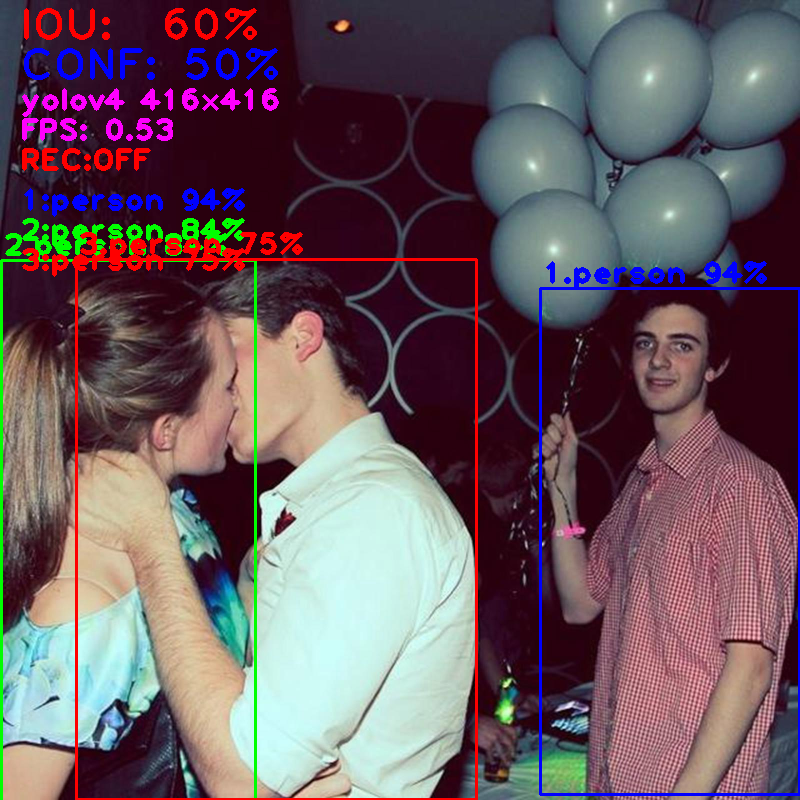

In [ ]:
""" Run detection on image from the web. """
Det = Detection(model_name = 'yolov4', input_height=416, path_yolo_classes='coco.txt', 
                 output_height=800, is_scale_output = True, MIN_confidence=0.5, IOU_threshold=0.8, 
                 is_blob_aspect_ratio=True, anchor_box_show=False, grid_show=False, show_text_on_box=True, 
                 is_recording=False, show_text_left=True)
Det.configure_net()
url_to_img = '''
https://www.thesun.co.uk/wp-content/uploads/2018/05/nintchdbpict000404123429.jpg
'''

try:
    req = Request(url_to_img, headers={'User-Agent': 'Mozilla/5.0'})
    req = urlopen(req).read()
    arr = np.asarray(bytearray(req), dtype=np.uint8)
    img = cv2.imdecode(arr, -1)
    print('Image size {}.'.format(img.shape[:2]))
    if not int(img.shape[0]):
        print("You probably misspelled the file name or the file does not exist.")

    start_time = time.time()
    Det.detect(img)
    Det.FPS = 1/(time.time() - start_time)
    Det.draw_img()   
except urllib.error.HTTPError:
    print("This file probably does not exist(check if you paste it correctly) or it is protected.")
    print(traceback.format_exc())   